# Project 3: Webscraping, NLP and classification modelling

# Contents:

1) Preprocessing Function  
2) Model 1 - CountVectorizer and Logistic Regression  
3) Model 2 - CountVectorizer and Naive Bayes  
4) Model 3 - TF-IDF and Logistic Regression  
5) Model 4 - TF-IDF and Naive Bayes  
6) Model Evaluation

# Imports and Natural Language Processing

In [1]:
# library imports
import requests
import time
import pandas as pd
import numpy as np
import ast
import regex as re
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing and modelling imports
from bs4 import BeautifulSoup 
from nltk.corpus import stopwords 
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')



In [2]:
df = pd.read_csv('../datasets/post_EDA_30_nov_df.csv')

In [3]:
df.shape

(1743, 11)

In [4]:
df.head()

,title,post,upvotes,gilded,belongs_to_sub2,title_x_post,token,joined_text,highly_upvoted,word_count,char_count
0,Just need to vent...,"I get that tempers are shorter these days, but...",230,0,0,Just need to vent... I get that tempers are sh...,"['need', 'vent', 'get', 'tempers', 'shorter', ...",Just need to vent... I get that tempers are sh...,1,48,579
1,Reverse call center post,On mobile so I hope I do this right. \n\nI ha...,39,0,0,Reverse call center post On mobile so I hope I...,"['reverse', 'call', 'center', 'post', 'mobile'...",Reverse call center post On mobile so I hope I...,0,84,1017
2,"""So you're willing to lose a customer for $3 d...",I work for a car rental company as a specialis...,763,0,0,"""So you're willing to lose a customer for $3 d...","['willing', 'lose', 'customer', 'dollars', 'wo...","""So you're willing to lose a customer for $3 d...",1,585,6757
3,Free Talk Friday - Nov 27,Welcome to Free Talk Friday! We are suspending...,0,0,0,Free Talk Friday - Nov 27 Welcome to Free Talk...,"['free', 'talk', 'friday', 'nov', 'welcome', '...",Free Talk Friday - Nov 27 Welcome to Free Talk...,0,38,368
4,Accidentally Exposed a Family Fraud,I work for a small local ISP. One of the thin...,958,0,0,Accidentally Exposed a Family Fraud I work for...,"['accidentally', 'exposed', 'family', 'fraud',...",Accidentally Exposed a Family Fraud I work for...,1,366,3608


In [72]:
def preprocessing(raw_text):
    
    # 1. Convert to lowercase
    lower_text = raw_text.lower()
    
    # 2. Remove punctuation
    letters_only = re.sub("[^a-z]",     # The pattern to search for
                          " ",          # The pattern to replace it with
                          lower_text )  # The text to search
    
    # 3. Split and lemmatize words
    words = letters_only.split()
    lemmatizer = WordNetLemmatizer()
    words_lem = [lemmatizer.lemmatize(i) for i in words]
     
    # 4. Remove stop words
    stops = stopwords.words('english')
    stops.append('gt')stops = stopwords.words('english')
    stops.append('gt')
    meaningful_words = [w for w in words if w not in stops]

    
    # 5. Join the words back into one string separated by space, 
    # and return the result.
    return (' '.join(meaningful_words))

In [73]:
df['cleaned_text']=df['title_x_post'].map(preprocessing)

In [74]:
df.to_csv('../datasets/cleaned_for_modelling_30_nov_df.csv', index=False)

In [75]:
df.head()

,title,post,upvotes,gilded,belongs_to_sub2,title_x_post,token,joined_text,highly_upvoted,word_count,char_count,cleaned_text
0,Just need to vent...,"I get that tempers are shorter these days, but...",230,0,0,Just need to vent... I get that tempers are sh...,"['need', 'vent', 'get', 'tempers', 'shorter', ...",Just need to vent... I get that tempers are sh...,1,48,579,need vent get tempers shorter days hard time l...
1,Reverse call center post,On mobile so I hope I do this right. \n\nI ha...,39,0,0,Reverse call center post On mobile so I hope I...,"['reverse', 'call', 'center', 'post', 'mobile'...",Reverse call center post On mobile so I hope I...,0,84,1017,reverse call center post mobile hope right cal...
2,"""So you're willing to lose a customer for $3 d...",I work for a car rental company as a specialis...,763,0,0,"""So you're willing to lose a customer for $3 d...","['willing', 'lose', 'customer', 'dollars', 'wo...","""So you're willing to lose a customer for $3 d...",1,585,6757,willing lose customer dollars work car rental ...
3,Free Talk Friday - Nov 27,Welcome to Free Talk Friday! We are suspending...,0,0,0,Free Talk Friday - Nov 27 Welcome to Free Talk...,"['free', 'talk', 'friday', 'nov', 'welcome', '...",Free Talk Friday - Nov 27 Welcome to Free Talk...,0,38,368,free talk friday nov welcome free talk friday ...
4,Accidentally Exposed a Family Fraud,I work for a small local ISP. One of the thin...,958,0,0,Accidentally Exposed a Family Fraud I work for...,"['accidentally', 'exposed', 'family', 'fraud',...",Accidentally Exposed a Family Fraud I work for...,1,366,3608,accidentally exposed family fraud work small l...


In [76]:
X = df['cleaned_text']
y = df['belongs_to_sub2']

In [77]:
#baseline model accuray 
y.value_counts(normalize=True)

1    0.516925
0    0.483075
Name: belongs_to_sub2, dtype: float64

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    stratify=y, #to keep the same balance of y in the test and train data
                                                    random_state = 42)


In [79]:
X_train.head()

195     wish hold existed real life women put men hold...
53      job look account instead idiot today customer ...
1704    customer demands ship replacement story share ...
1043    videowall cost cuts continuation previous post...
1193    know passwords level tech support universities...
Name: cleaned_text, dtype: object

In [13]:
X_train.shape

(1307,)

In [15]:
# Instantiate a CountVectorizer.
cvec = CountVectorizer()

# Fit the vectorizer on our corpus.
cvec.fit(X_train)

# Transform the corpus.
X_train_cvec = cvec.transform(X_train)

# Transform the test.
X_test_cvec = cvec.transform(X_test)

In [16]:
# Convert X_train into a DataFrame.

X_train_df = pd.DataFrame(X_train_cvec.toarray(),
                          columns=cvec.get_feature_names())
X_train_df.head()

,aa,aaa,aaaa,aaaaaand,aaaaand,aaaahhhhh,aaaalright,aaaand,aaaggghhh,aaahh,...,zone,zoned,zoom,zoomed,zooming,zork,zuckerburg,zulu,zzz,zzzzzzzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


So from here we can see the size of vocabulary is 16,000 words

# Model 1: CountVectorizer & Logistic Regression

In [17]:
# set a pipeline up with two stages:
# 1. CountVectorizer (transformer)
# 2. LogisticRegression (estimator)

pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())
])

# Search over the following values of hyperparameters:
# Maximum number of features fit: 5000, 10,000, 15,000
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and 2-grams).

pipe_params = {
    'cvec__max_features' : [5_000, 10_000, 15_000],
    'cvec__min_df' : [2,3],
    'cvec__max_df': [0.9, 0.95],
    'cvec__ngram_range' : [(1,1), (1,2)]
}

# Instantiate GridSearchCV.

gs = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid = pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.


In [18]:
# Fit GridSearch to training data.
gs.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('lr', LogisticRegression())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [5000, 10000, 15000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)]})

In [19]:
# What's the best score?
gs.best_score_

0.9250504518732999

In [20]:
gs.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 10000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2)}

In [21]:
# Save best model as gs_model.

gs_model = gs.best_estimator_

In [22]:
# Score model on training set.
print(f'Train score is {gs_model.score(X_train, y_train)}')

Train score is 0.9992348890589136


In [23]:
# Score model on testing set.
print(f'Test score is {gs_model.score(X_test, y_test)}')

Test score is 0.9288990825688074


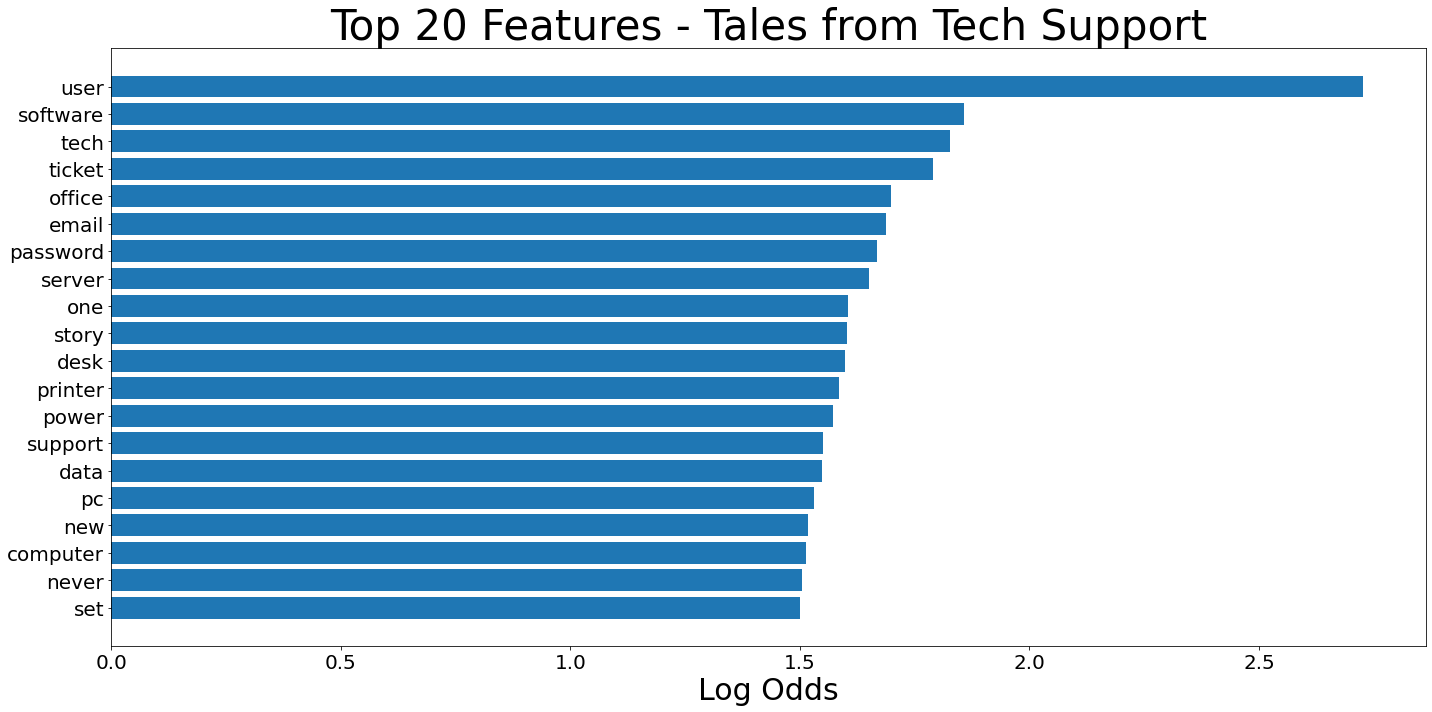

In [24]:
beta = gs.best_estimator_.named_steps['lr'].coef_

vocab = gs.best_estimator_.named_steps['cvec'].get_feature_names()

beta_df = pd.DataFrame( {'top_words': vocab, 'Beta' :beta[0]})
beta_df['log_odds'] = beta_df['Beta'].map(lambda x: np.exp(x))
beta_df = beta_df.set_index('top_words')
beta_df = beta_df.sort_values('log_odds',ascending = False)

weights = beta_df['log_odds'].head(20).sort_values()
labels = weights.index

plt.figure(figsize=(20,10))
plt.barh(labels, weights)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Log Odds', fontsize=30)
plt.title(f'Top 20 Words - Tales from Tech Support', fontsize=42)
plt.tight_layout()



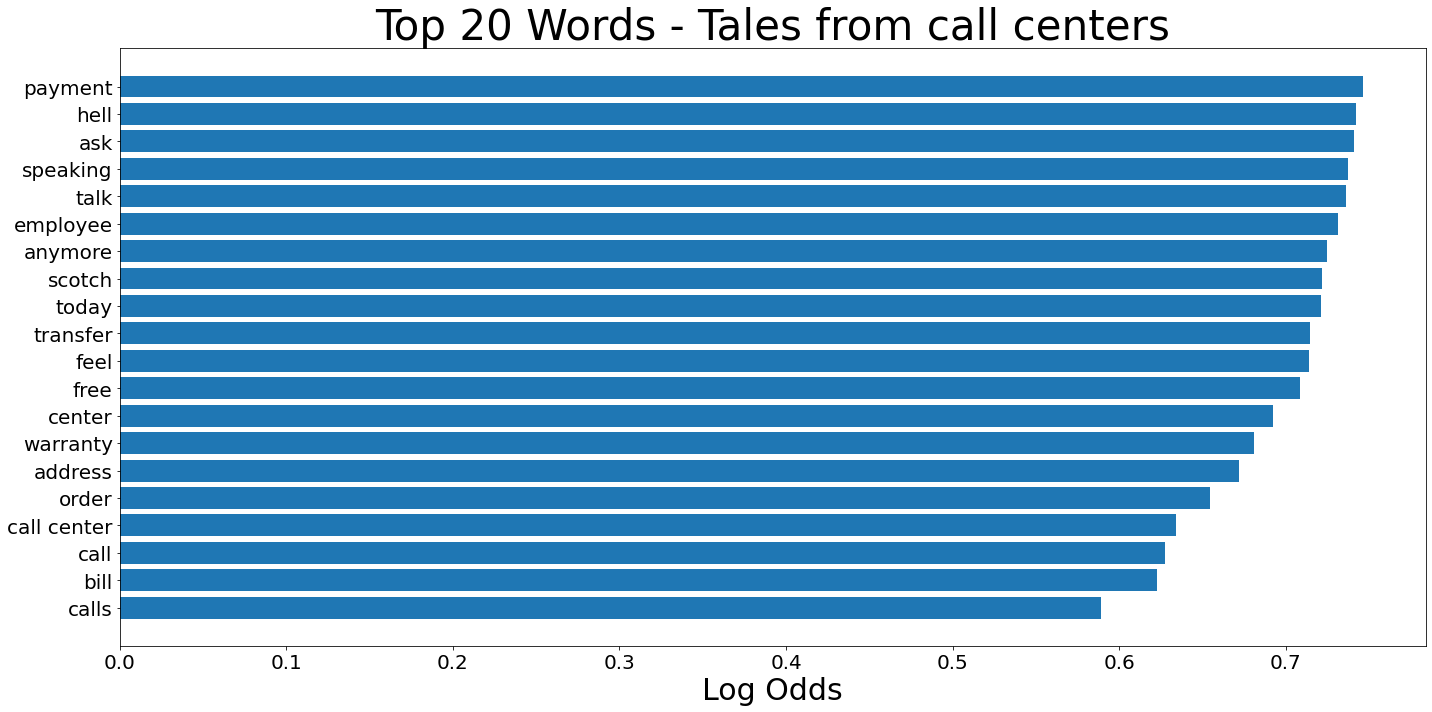

In [26]:
weights = beta_df['log_odds'].tail(20).sort_values()
labels = weights.index

plt.figure(figsize=(20,10))
plt.barh(labels, weights)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Log Odds', fontsize=30)
plt.title(f'Top 20 Words - Tales from call centers', fontsize=42)
plt.tight_layout()


In [27]:
#creating a confusion matrix

y_pred = gs.predict(X_test)
cm_def = np.array([['True Negative', 'False Positive'],
                ['False Negative', 'True Positive']])
cm_def = pd.DataFrame(cm_def,columns = ['pred neg', 'pred pos'], index = ['actual neg','actual pos'])
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, columns = ['pred neg', 'pred pos'], index = ['actual neg','actual pos'])
display(cm_def)
display(cm_df)

,pred neg,pred pos
actual neg,True Negative,False Positive
actual pos,False Negative,True Positive


,pred neg,pred pos
actual neg,199,12
actual pos,19,206


# Model 2: CountVectorizer & Naive Bayes

In [80]:
# set a pipeline up with two stages:
# 1. CountVectorizer (transformer)
# 2. Naive Bayes (estimator)

pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

# Search over the following values of hyperparameters:
# Maximum number of features fit: 5000, 10,000, 15,000
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and 2-grams).

pipe_params = {
    'cvec__max_features' : [5_000, 10_000, 15_000],
    'cvec__min_df' : [2,3],
    'cvec__max_df': [0.9, 0.95],
    'cvec__ngram_range' : [(1,1), (1,2)]
}

# Instantiate GridSearchCV.

gs = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid = pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.



In [81]:
# Fit GridSearch to training data.
gs.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [5000, 10000, 15000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)]})

In [82]:
# What's the best score?
gs.best_score_

0.9380187768711064

In [83]:
gs.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 5000,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 2)}

In [84]:
# Save best model as gs_model.

gs_model = gs.best_estimator_

In [85]:
# Score model on training set.
print(f'Train score is {gs_model.score(X_train, y_train)}')
# Score model on testing set.
print(f'Test score is {gs_model.score(X_test, y_test)}')

Train score is 0.9671002295332823
Test score is 0.944954128440367


In [86]:
y_pred = gs.predict(X_test)
cm_def = np.array([['True Negative', 'False Positive'],
                ['False Negative', 'True Positive']])
cm_def = pd.DataFrame(cm_def,columns = ['pred neg', 'pred pos'], index = ['actual neg','actual pos'])
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, columns = ['pred neg', 'pred pos'], index = ['actual neg','actual pos'])
display(cm_def)
display(cm_df)

,pred neg,pred pos
actual neg,True Negative,False Positive
actual pos,False Negative,True Positive


,pred neg,pred pos
actual neg,203,8
actual pos,16,209


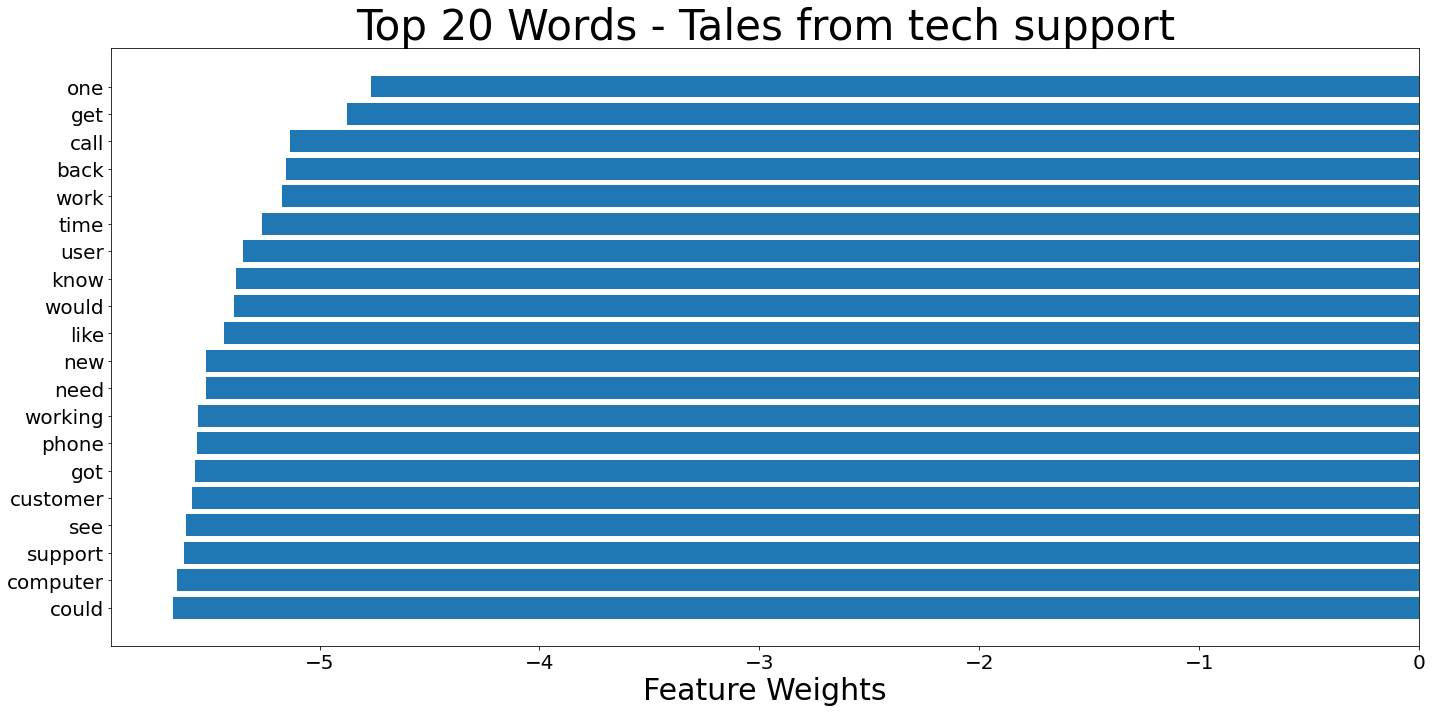

In [87]:
vocab = gs.best_estimator_.named_steps['cvec'].get_feature_names()

coef = list(gs.best_estimator_.named_steps['nb'].coef_[0])

feature_df = pd.DataFrame( {'top_words': vocab, 'importance': coef })

feature_df = feature_df.set_index('top_words')
feature_df = feature_df.sort_values('importance',ascending = False)

weights = feature_df['importance'].head(20).sort_values()
labels = weights.index

plt.figure(figsize=(20,10))
plt.barh(labels, weights)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Feature Weights', fontsize=30)
plt.title(f'Top 20 Words - Tales from tech support', fontsize=42)
plt.tight_layout()



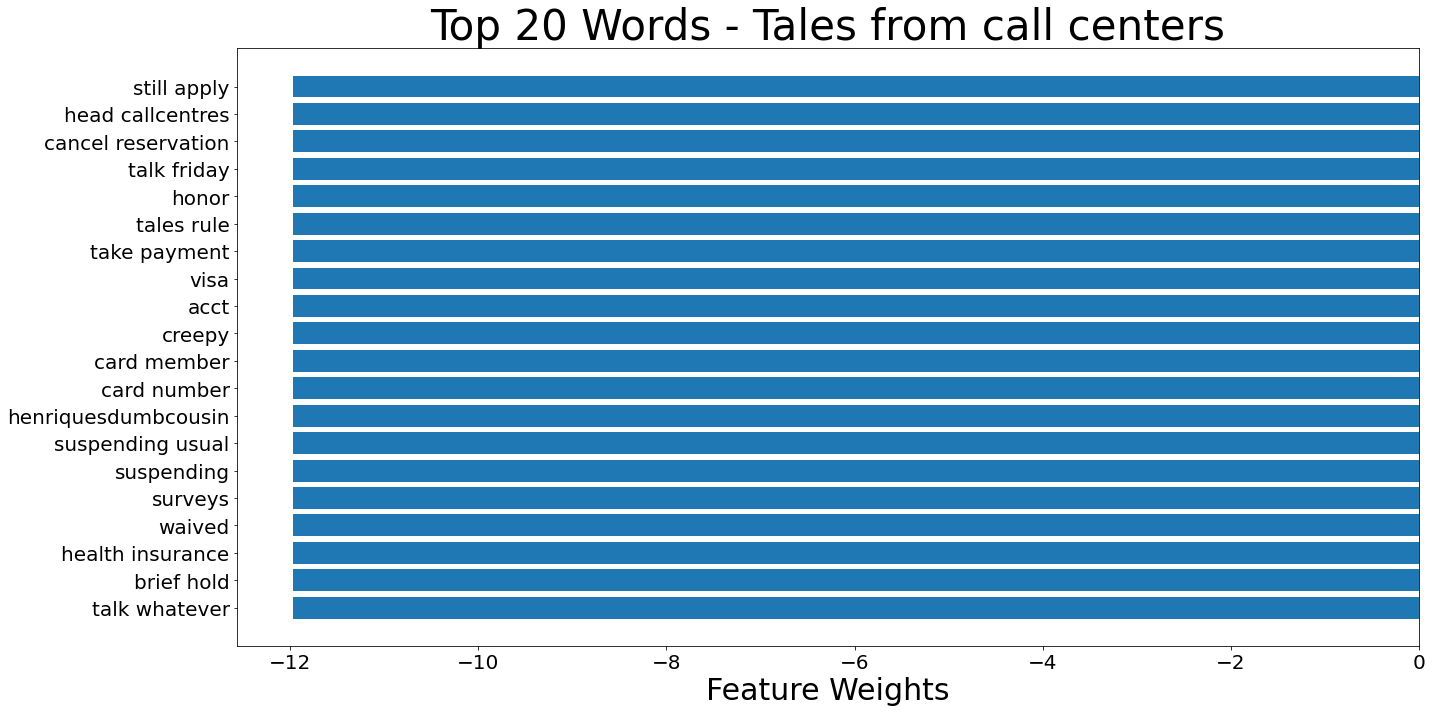

In [88]:

weights = feature_df['importance'].tail(20).sort_values()
labels = weights.index

plt.figure(figsize=(20,10))
plt.barh(labels, weights)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Feature Weights', fontsize=30)
plt.title(f'Top 20 Words - Tales from call centers', fontsize=42)
plt.tight_layout()



# Model 3: TF - IDF Vectorizer & Logistic Regression

In [89]:
pipe2 = Pipeline([
                ('tf', TfidfVectorizer()),
                ('lr', LogisticRegression())
])

params2 = {
                'tf__max_features' : [5000,10_000,15_000],
                'tf__ngram_range' : [(1,1), (1,2)]
}

gs2 = GridSearchCV(pipe2, param_grid = params2, cv = 5)

In [90]:
gs2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('lr', LogisticRegression())]),
             param_grid={'tf__max_features': [5000, 10000, 15000],
                         'tf__ngram_range': [(1, 1), (1, 2)]})

In [91]:
# What's the best score?
gs2.best_score_

0.9364949840601327

In [92]:
gs2.best_params_

{'tf__max_features': 15000, 'tf__ngram_range': (1, 2)}

In [93]:
# Save best model as gs_model.

gs_model = gs2.best_estimator_

In [94]:
# Score model on training set.
print(f'Train score is {gs_model.score(X_train, y_train)}')
# Score model on testing set.
print(f'Test score is {gs_model.score(X_test, y_test)}')

Train score is 0.9831675592960979
Test score is 0.9334862385321101


In [95]:
y_pred = gs2.predict(X_test)
cm_def = np.array([['True Negative', 'False Positive'],
                ['False Negative', 'True Positive']])
cm_def = pd.DataFrame(cm_def,columns = ['pred neg', 'pred pos'], index = ['actual neg','actual pos'])
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, columns = ['pred neg', 'pred pos'], index = ['actual neg','actual pos'])
display(cm_def)
display(cm_df)

,pred neg,pred pos
actual neg,True Negative,False Positive
actual pos,False Negative,True Positive


,pred neg,pred pos
actual neg,199,12
actual pos,17,208


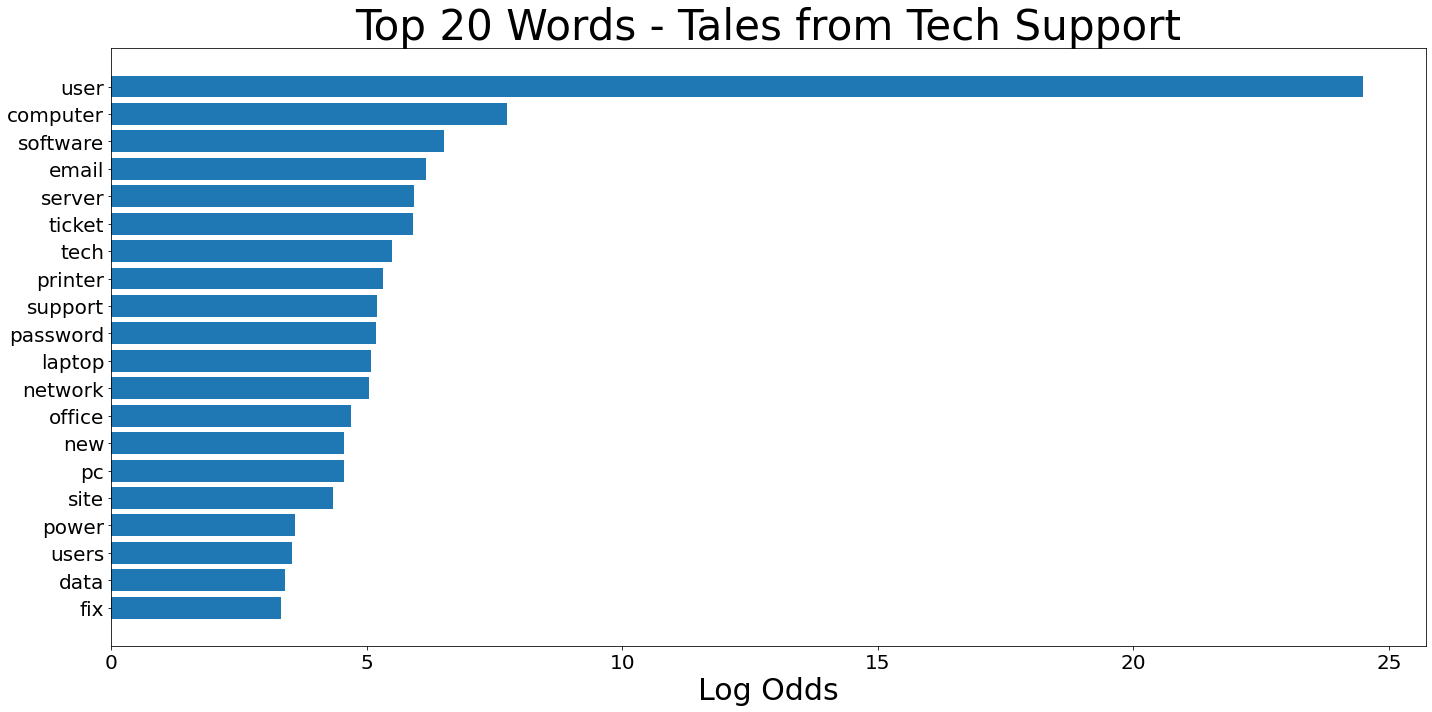

In [96]:
beta = gs2.best_estimator_.named_steps['lr'].coef_

vocab = gs2.best_estimator_.named_steps['tf'].get_feature_names()

beta_df = pd.DataFrame( {'top_words': vocab, 'Beta' :beta[0]})
beta_df['log_odds'] = beta_df['Beta'].map(lambda x: np.exp(x))
beta_df = beta_df.set_index('top_words')
beta_df = beta_df.sort_values('log_odds',ascending = False)

weights = beta_df['log_odds'].head(20).sort_values()
labels = weights.index

plt.figure(figsize=(20,10))
plt.barh(labels, weights)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Log Odds', fontsize=30)
plt.title(f'Top 20 Words - Tales from Tech Support', fontsize=42)
plt.tight_layout()




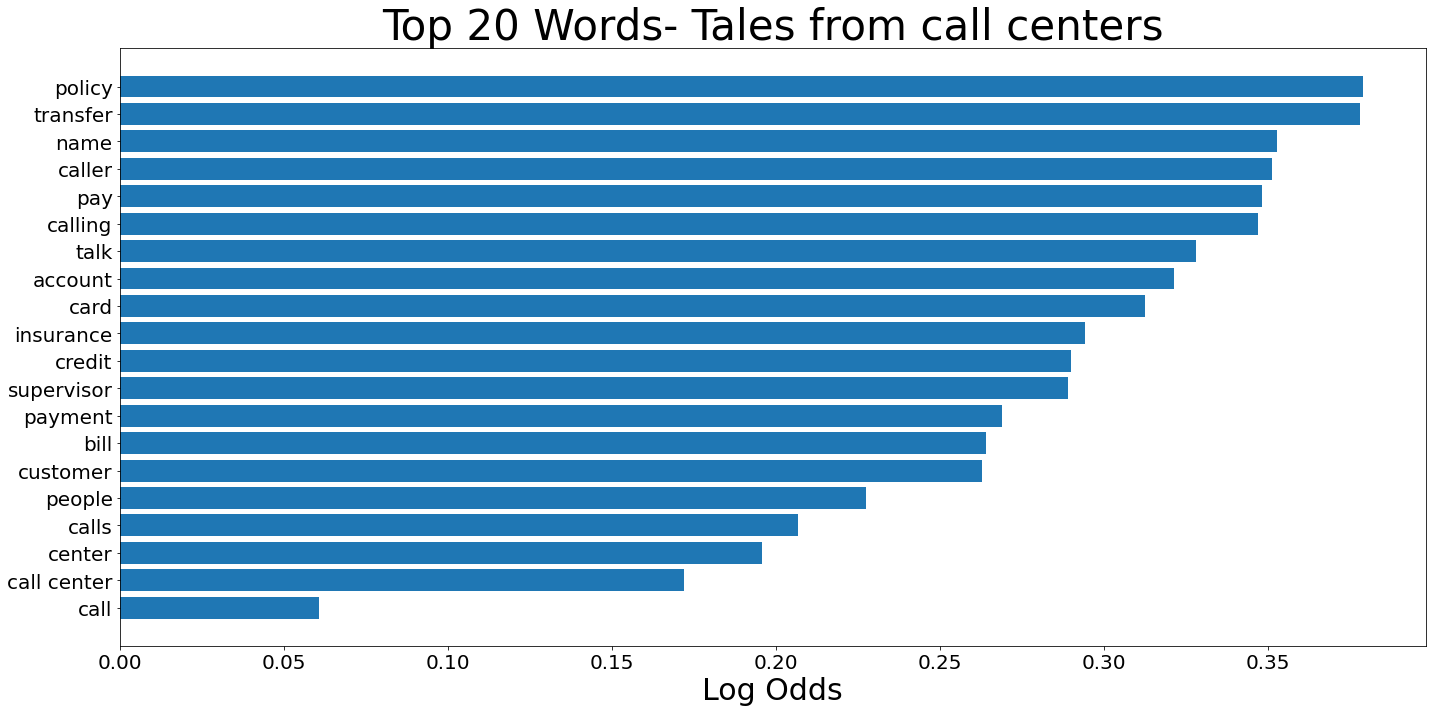

In [97]:
weights = beta_df['log_odds'].tail(20).sort_values()
labels = weights.index

plt.figure(figsize=(20,10))
plt.barh(labels, weights)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Log Odds', fontsize=30)
plt.title(f'Top 20 Words- Tales from call centers', fontsize=42)
plt.tight_layout()

# Model 4: TF - IDF Vectorizer & Multinomial Naive Bayes

In [98]:
pipe2 = Pipeline([
                ('tf', TfidfVectorizer()),
                ('nb', MultinomialNB())
])

params2 = {
                'tf__max_features' : [5000,10_000,15_000],
                'tf__ngram_range' : [(1,1), (1,2)]
}

gs2 = GridSearchCV(pipe2, param_grid = params2, cv = 5)

In [99]:
gs2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'tf__max_features': [5000, 10000, 15000],
                         'tf__ngram_range': [(1, 1), (1, 2)]})

In [100]:
gs2.best_params_

{'tf__max_features': 10000, 'tf__ngram_range': (1, 1)}

In [101]:
gs_train_accuracy = round(gs2.score(X_train, y_train),2)
print(f'Train Accuracy: {gs_train_accuracy}')

Train Accuracy: 0.98


In [102]:
gs_test_accuracy = round(gs2.score(X_test, y_test),2)
print(f'Test Accuracy: {gs_test_accuracy}')

Test Accuracy: 0.93


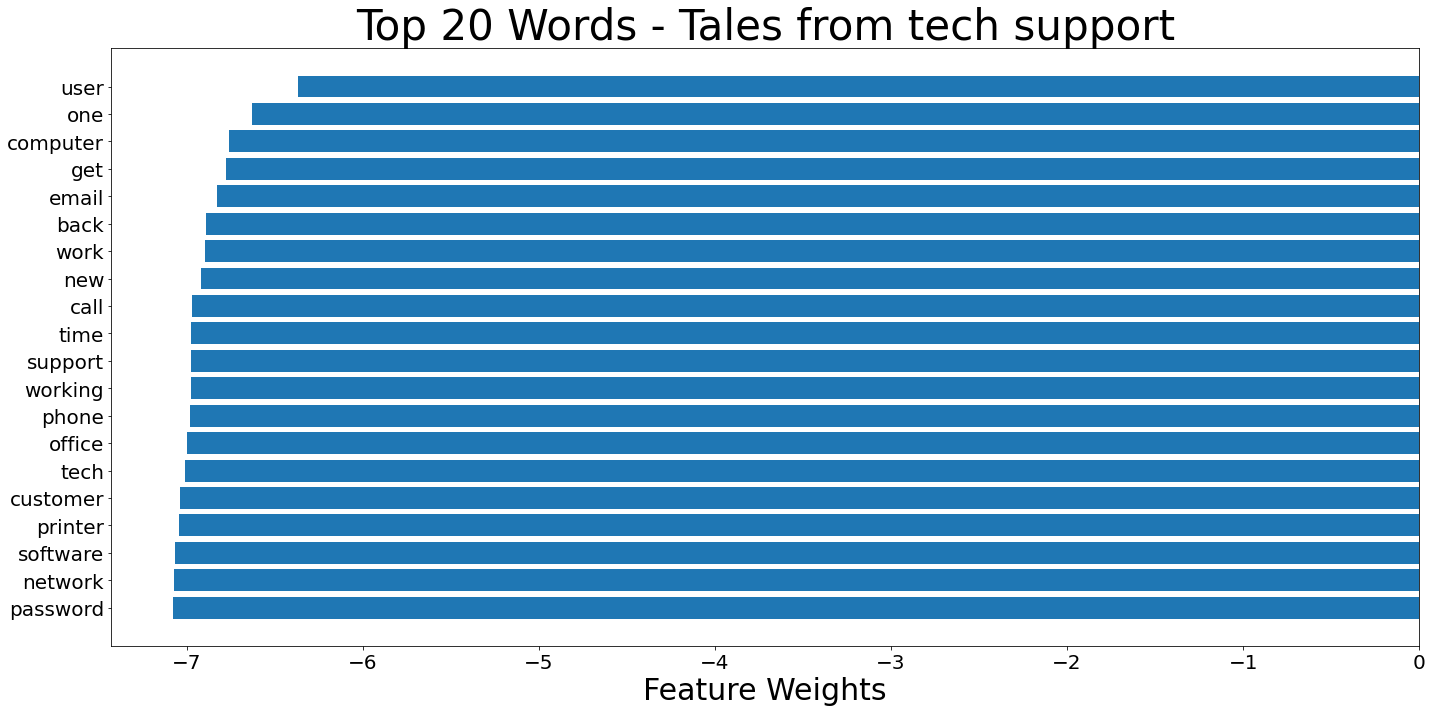

In [103]:
vocab = gs2.best_estimator_.named_steps['tf'].get_feature_names()

coef = list(gs2.best_estimator_.named_steps['nb'].coef_[0])

feature_df = pd.DataFrame( {'top_words': vocab, 'importance': coef })

feature_df = feature_df.set_index('top_words')
feature_df = feature_df.sort_values('importance',ascending = False)

weights = feature_df['importance'].head(20).sort_values()
labels = weights.index

plt.figure(figsize=(20,10))
plt.barh(labels, weights)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Feature Weights', fontsize=30)
plt.title(f'Top 20 Words - Tales from tech support', fontsize=42)
plt.tight_layout()


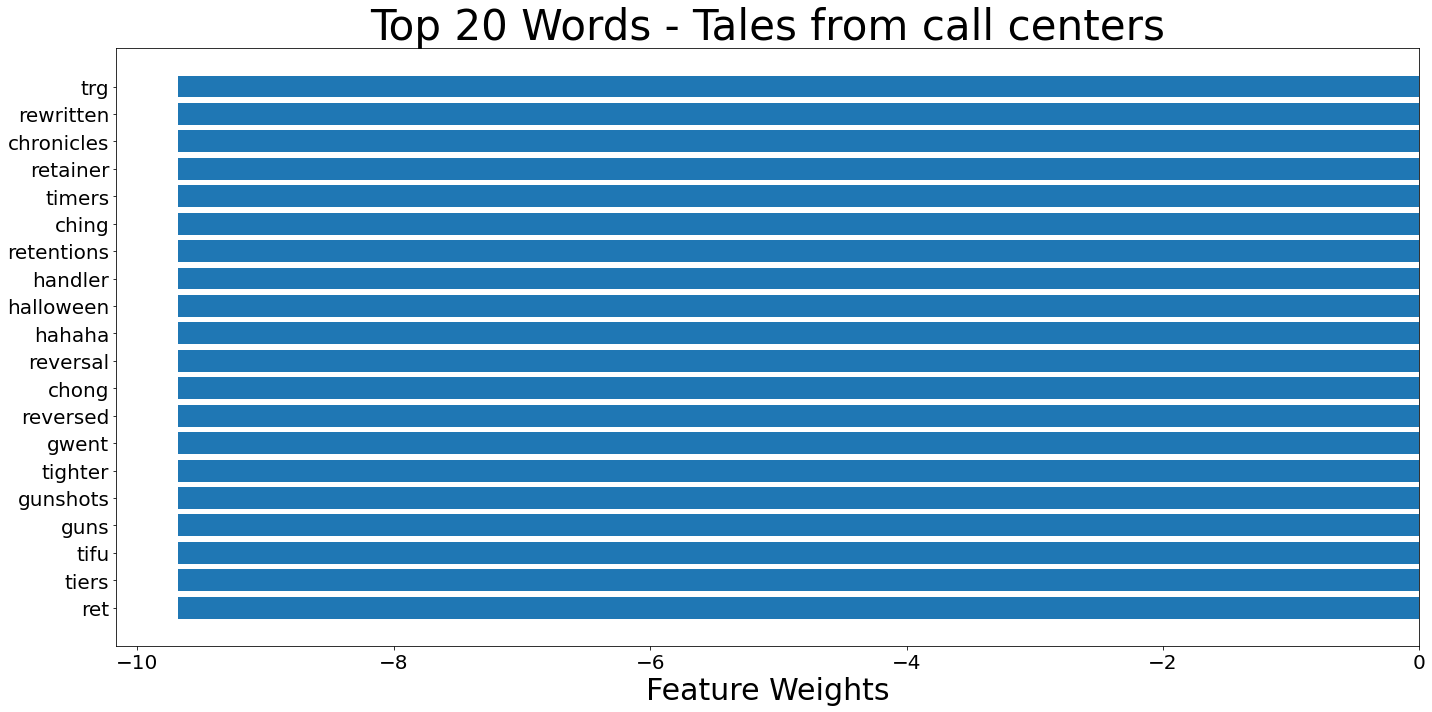

In [104]:
weights = feature_df['importance'].tail(20).sort_values()
labels = weights.index

plt.figure(figsize=(20,10))
plt.barh(labels, weights)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Feature Weights', fontsize=30)
plt.title(f'Top 20 Words - Tales from call centers', fontsize=42)
plt.tight_layout()



In [53]:
y_pred_2 = gs2.predict(X_test)

In [54]:
cm = confusion_matrix(y_test, y_pred_2)
cm_df = pd.DataFrame(cm, columns = ['pred neg', 'pred pos'], index = ['actual neg','actual pos'])

In [55]:
display(cm_def)
display(cm_df)

,pred neg,pred pos
actual neg,True Negative,False Positive
actual pos,False Negative,True Positive


,pred neg,pred pos
actual neg,198,13
actual pos,12,213


# Model Selection

Top 2 Models in terms of accuracy- 

Transformer: TF-IDF  
Estimator: Naive Bayes (Hyperparameters - 'tf__max_features': 10000, 'tf__ngram_range': (1, 2))  
Accuracy: 94%


Transformer: CountVectorizer  
Estimator: Naive Bayes (Hyperparameters - 'cvec__max_df': 0.9, 'cvec__max_features': 10000, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 2)}  
Accuracy: 95%. 

Currently, Naive Bayes appears to be a better model for this dataset, with both CVEC and TF-IDF having 94% accuracy. As the end goal is to accurately classify posts belonging to call centers, this is the preferred metric to optimize on, as opposed to sensitivity/specificity/precision.

In the next step, I will explore more advanced models using Decision Trees and Boosting before final model selection/optimization.

#### Note: Although NB has a better score, models with log reg are more interpretable and answer the business question better. Therefore I will look at a logreg model in final testing.